In [4]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/ramarty/Projects/hla_ii/bin/imports.ipynb")

Populating the interactive namespace from numpy and matplotlib


## Multi-class predictor

In [2]:
tissue_df = pd.read_csv('/cellar/users/ramarty/Data/hla/git_data/data/patient_tissues.csv', index_col=0)

In [3]:
def feature_selection(X):
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, Y)
    model = SelectFromModel(lsvc, prefit=True)
    X = model.transform(X)
    return X

Predicting from mutations

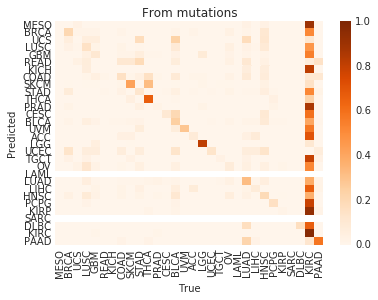

In [4]:
mutations = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_mutations.csv', index_col=0)
ancestry = pd.read_csv('/cellar/users/ramarty/Data/hla/git_data/data/clinical/ancestory.csv', index_col=0)
white_patients = [x for x in list(ancestry[ancestry.race == 'WHITE'].index) if x in mutations.index]
#patients = [x for x in tissue_df.index if x in mutations.index]
patients = white_patients
len(patients)
X = mutations.ix[patients].as_matrix()
Y = tissue_df.ix[patients].Tissue
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=41)
clf = RandomForestClassifier()
clf = clf.fit(X_train, Y_train)
predicted = clf.predict(X_test)
tissues = list(tissue_df.Tissue.unique())
matrix = []
for true_tissue in tissues:
    array = []
    for predicted_tissue in tissues:
        try:
            number_predicted = len([x for x,y in zip(list(Y_test), predicted) if x == true_tissue and y == predicted_tissue])
            number_true = len([x for x in Y_test if x == true_tissue])
            #print true_tissue, predicted_tissue, number_true, number_predicted
            array.append(float(number_predicted)/float(number_true))
        except:
            array.append(np.nan)
    matrix.append(array)
sns.heatmap(matrix, xticklabels=tissues, yticklabels=tissues, cmap="Oranges", vmax=1, vmin=0)
plt.title('From mutations')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/predictions/tissues/all_v_all.mutations.pdf')

Predicting from PHBRs

In [5]:
classI = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_affinities.class_i.alternate.csv', index_col=0)
classII = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_affinities.class_ii.alternate.csv', index_col=0)
both_alternative = pd.concat([classI.transpose(), classII.transpose()]).transpose()

In [6]:
classI = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_affinities.class_i.csv', index_col=0)
classII = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_affinities.class_ii.csv', index_col=0)
both = pd.concat([pd.concat([classI.transpose(), classII.transpose()]).transpose(), both_alternative])
print len(white_patients)
#patients = [x for x in tissue_df.index if x in both.index]
patients = white_patients+list(both_alternative.index)
print len(patients)
X = both.ix[patients].as_matrix()
Y = tissue_df.ix[patients].Tissue
print len(X), len(Y)

5146
5589
5589 5589


/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


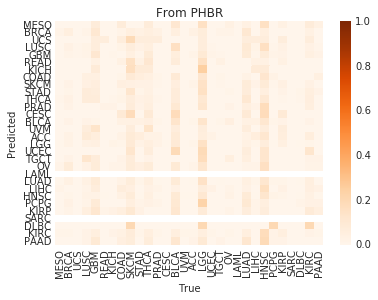

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
clf = RandomForestClassifier()
clf = clf.fit(X_train, Y_train)
predicted = clf.predict(X_test)
tissues = list(tissue_df.Tissue.unique())
matrix = []
for true_tissue in tissues:
    array = []
    for predicted_tissue in tissues:
        try:
            number_predicted = len([x for x,y in zip(list(Y_test), predicted) if x == true_tissue and y == predicted_tissue])
            number_true = len([x for x in Y_test if x == true_tissue])
            #print true_tissue, predicted_tissue, number_true, number_predicted
            array.append(float(number_predicted)/float(number_true))
        except:
            array.append(np.nan)
    matrix.append(array)
sns.heatmap(matrix, xticklabels=tissues, yticklabels=tissues, cmap="Oranges", vmax=1, vmin=0)
plt.title('From PHBR')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/predictions/tissues/all_v_all.PHBR.pdf')

In [8]:
m = pd.DataFrame(matrix)
m.columns = tissues
m.index = tissues

### Predict one tissue from others

From mutations

In [17]:
tissue = 'HNSC'

Number of patients with tissue:  403
Number of patients with other:  4743
Weight shift:  11.7692307692
0.0


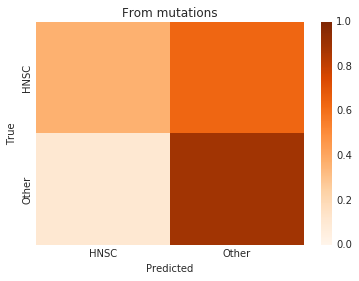

In [18]:
#tissue_patients = [x for x in list(tissue_df[tissue_df.Tissue == tissue].index) if x in list(classI.index)]
#other_patients = [x for x in list(pd.Series(tissue_df[tissue_df.Tissue != tissue].index)) if x in list(classI.index)]
tissue_patients = [x for x in list(tissue_df[tissue_df.Tissue == tissue].index) if x in white_patients]
other_patients = [x for x in list(pd.Series(tissue_df[tissue_df.Tissue != tissue].index)) if x in white_patients]
print 'Number of patients with tissue: ', len(tissue_patients)
print 'Number of patients with other: ', len(other_patients)
weight_shift = float(len(other_patients))/len(tissue_patients)
print 'Weight shift: ', weight_shift
def is_tissue(x):
    if x == tissue:
        return 1
    else:
        return 0
tissue_df['Single'] = tissue_df['Tissue'].apply(is_tissue)
X = mutations.ix[tissue_patients + other_patients].as_matrix()
Y = tissue_df.ix[tissue_patients + other_patients].Single
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=40)
#clf = RandomForestClassifier(class_weight={1:weight_shift, 0:1})
#clf = clf.fit(X_train, Y_train)
#predicted = clf.predict(X_test)

skf = StratifiedKFold(n_splits=10)
all_predicted, all_Y_test, all_X_test, predicted_probabilities = [], [], [], []
for train, test in skf.split(X, Y):
    #clf = RandomForestClassifier(min_weight_fraction_leaf=.15, class_weight={'Tissue':weight_shift, 'Other':1})
    clf = RandomForestClassifier(class_weight={1:weight_shift,  0:1})
    # change this into cross validation
    clf = clf.fit(X[train], Y[train])
    predicted = clf.predict(X[test])
    all_predicted.extend(predicted)
    all_Y_test.extend(Y[test])
    all_X_test.extend(X[test])
    predicted_probabilities.extend(clf.predict_proba(X[test])[:,1])


mutations_clf = clf
mutations_X_test = all_X_test
mutations_Y_test = all_Y_test

#mutations_X_test = X_test
#mutations_Y_test = predicted
matrix = []
for true_tissue in [1, 0]:
    array = []
    for predicted_tissue in [1, 0]:
        try:
        #if true_tissue == predicted_tissue:
            number_predicted = len([x for x,y in zip(list(all_Y_test), all_predicted) if x == true_tissue and y == predicted_tissue])
            number_true = len([x for x in all_Y_test if x == true_tissue])
            #print true_tissue, predicted_tissue, number_true, number_predicted
            array.append(float(number_predicted)/float(number_true))
        except:
            array.append(np.nan)
    matrix.append(array)
sns.heatmap(matrix, xticklabels=[tissue, 'Other'], yticklabels=[tissue, 'Other'], cmap="Oranges", vmax=1, vmin=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('From mutations')
matrix
print len([x for x,y in zip(Y_test, predicted) if x == y])/float(len(Y_test))

From PHBR

1018
(5146, 2036)
[[0.456575682382134, 0.543424317617866], [0.38098250052709254, 0.6190174994729074]]
0.606296152351


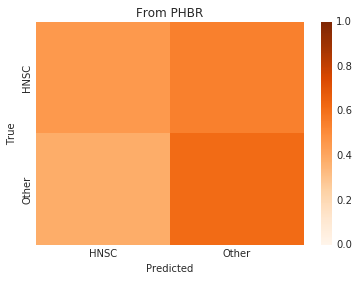

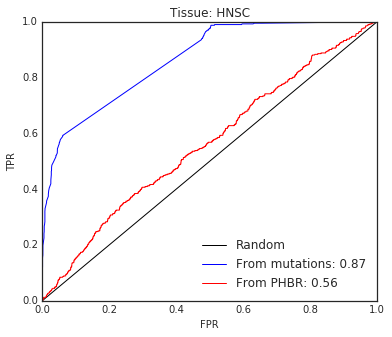

In [19]:
# Predictions
high_mutations = list(mutations.ix[tissue_patients].sum()[mutations.ix[tissue_patients].sum() >= 0].index)
#both_restricted = classI
both_restricted = both[high_mutations]
print len(high_mutations)
X = both_restricted.ix[tissue_patients + other_patients].as_matrix()
Y = tissue_df.ix[tissue_patients + other_patients].Single
# X = feature_selection(X)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=41)
print X.shape
skf = StratifiedKFold(n_splits=10)
all_predicted, all_Y_test, all_X_test, predicted_probabilities = [], [], [], []
for train, test in skf.split(X, Y):
    #clf = RandomForestClassifier(min_weight_fraction_leaf=.15, class_weight={'Tissue':weight_shift, 'Other':1})
    clf = RandomForestClassifier(min_weight_fraction_leaf=.2, class_weight={1:weight_shift})
    # change this into cross validation
    clf = clf.fit(X[train], Y[train])
    predicted = clf.predict(X[test])
    all_predicted.extend(predicted)
    all_Y_test.extend(Y[test])
    all_X_test.extend(X[test])
    predicted_probabilities.extend(clf.predict_proba(X[test])[:,1])
    tmp = pd.DataFrame({'Mutation': high_mutations+high_mutations, 'Importance': clf.feature_importances_})
    #print tmp.sort_values('Importance', ascending=False).head()

    
matrix = []
for true_tissue in [1, 0]:
    array = []
    for predicted_tissue in [1, 0]:
        try:
        #if true_tissue == predicted_tissue:
            number_predicted = len([x for x,y in zip(list(all_Y_test), all_predicted) if x == true_tissue and y == predicted_tissue])
            number_true = len([x for x in all_Y_test if x == true_tissue])
            #print true_tissue, predicted_tissue, number_true, number_predicted
            array.append(float(number_predicted)/float(number_true))
        except:
            array.append(np.nan)
    matrix.append(array)
sns.heatmap(matrix, xticklabels=[tissue, 'Other'], yticklabels=[tissue, 'Other'], cmap="Oranges", vmax=1, vmin=0)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('From PHBR')

print matrix
real = len([x for x,y in zip(all_Y_test, all_predicted) if x == y])/float(len(all_Y_test))
print real

# Plot ROC
mutations_prediction_probabilities = mutations_clf.predict_proba(mutations_X_test)[:,1]


# Plot ROC
fpr_PHBR, tpr_PHBR, thresholds = metrics.roc_curve(all_Y_test, predicted_probabilities, pos_label=1)
fpr_mutations, tpr_mutations, thresholds = metrics.roc_curve(mutations_Y_test, mutations_prediction_probabilities, pos_label=1)
sns.set_style("white")
plt.figure(figsize=(6,5))
plt.plot([0,1], [0, 1], c='k', label='Random')
plt.plot(fpr_mutations, tpr_mutations, c='b', label='From mutations: {0}'.format(round(metrics.roc_auc_score(mutations_Y_test, 
                                                            mutations_prediction_probabilities),2)))
plt.plot(fpr_PHBR, tpr_PHBR, c='r', label='From PHBR: {0}'.format(round(metrics.roc_auc_score(all_Y_test, 
                                                            predicted_probabilities),2)))
plt.title('Tissue: {0}'.format(tissue))
plt.legend(loc=4)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/predictions/tissues/{0}.pdf'.format(tissue))
plt.show()
plt.clf()

In [20]:
clf = clf.fit(X, Y)
tmp = pd.DataFrame({'Mutation': high_mutations+high_mutations, 'Importance': clf.feature_importances_})
tmp.sort_values('Importance', ascending=False).head()

,Importance,Mutation
680,0.086442,PIK3R1_L56V
1075,0.070320,MB21D2_Q311E
949,0.058254,KMT2B_R2332C
51,0.057778,KRAS_Q61H
563,0.055781,TP53_R158H


Randomize to look for improvement

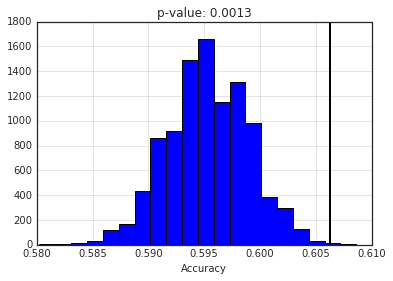

In [21]:
accuracy = []
for i in range(10000):
    random.shuffle(all_predicted)
    accuracy.append(len([x for x,y in zip(all_Y_test, all_predicted) if x == y])/float(len(all_Y_test)))
pd.Series(accuracy).hist(bins=20)
plt.axvline(real, lw=2, c='k')
plt.xlabel('Accuracy')
plt.title('p-value: {0}'.format(len([x for x in accuracy if real < x])/float(len(accuracy))))

Test all tissues:

In [128]:
tissue_used, cutoff_used, p_value, number_of_mutations = [], [], [], []

In [129]:
for cutoff in [0, 2, 5]:
    print "cutoff:", cutoff
    for tissue in tissues:
        print tissue
        tissue_patients = [x for x in list(tissue_df[tissue_df.Tissue == tissue].index) if x in patients]
        other_patients = [x for x in list(pd.Series(tissue_df[tissue_df.Tissue != tissue].index)) if x in patients]
        high_mutations = list(mutations.ix[tissue_patients].sum()[mutations.ix[tissue_patients].sum() >= cutoff].index)
        if len(high_mutations) == 0:
            continue
        #both_restricted = classI
        both_restricted = both[high_mutations]
        #print len(high_mutations)
        if len(tissue_patients) == 0:
            continue
        weight_shift = float(len(other_patients))/len(tissue_patients)
        def is_tissue(x):
            if x == tissue:
                return 'Tissue'
            else:
                return 'Other'
        tissue_df['Single'] = tissue_df['Tissue'].apply(is_tissue)
        X = both_restricted.ix[tissue_patients + other_patients].as_matrix()
        Y = tissue_df.ix[tissue_patients + other_patients].Single
        # X = feature_selection(X)
        #print X.shape
        for k in range(5):
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)
            # successful for LIHC
            #clf = RandomForestClassifier(min_weight_fraction_leaf=.15, class_weight={'Tissue':weight_shift, 'Other':1})
            clf = RandomForestClassifier(min_weight_fraction_leaf=.2, class_weight={'Tissue':weight_shift, 'Other':1})
            clf = clf.fit(X_train, Y_train)
            predicted = clf.predict(X_test)
            matrix = []
            for true_tissue in ['Tissue', 'Other']:
                array = []
                for predicted_tissue in ['Tissue', 'Other']:
                    try:
                    #if true_tissue == predicted_tissue:
                        number_predicted = len([x for x,y in zip(list(Y_test), predicted) if x == true_tissue and y == predicted_tissue])
                        number_true = len([x for x in Y_test if x == true_tissue])
                        #print true_tissue, predicted_tissue, number_true, number_predicted
                        array.append(float(number_predicted)/float(number_true))
                    except:
                        array.append(np.nan)
                matrix.append(array)
            real = len([x for x,y in zip(Y_test, predicted) if x == y])/float(len(Y_test))


            accuracy = []
            for i in range(1000):
                random.shuffle(predicted)
                matrix = []
                for true_tissue in ['Tissue', 'Other']:
                    array = []
                    for predicted_tissue in ['Tissue', 'Other']:
                        try:
                        #if true_tissue == predicted_tissue:
                            number_predicted = len([x for x,y in zip(list(Y_test), predicted) if x == true_tissue and y == predicted_tissue])
                            number_true = len([x for x in Y_test if x == true_tissue])
                            #print true_tissue, predicted_tissue, number_true, number_predicted
                            array.append(float(number_predicted)/float(number_true))
                        except:
                            array.append(np.nan)
                    matrix.append(array)
                accuracy.append(len([x for x,y in zip(Y_test, predicted) if x == y])/float(len(Y_test)))
            
            #print tissue, len([x for x in accuracy if real < x])/float(len(accuracy))
            tissue_used.append(tissue)
            cutoff_used.append(cutoff)
            p_value.append(len([x for x in accuracy if real < x])/float(len(accuracy)))
            number_of_mutations.append(len(high_mutations))

cutoff: 0
MESO
BRCA
UCS
LUSC
GBM
READ
KICH
COAD
SKCM
STAD
THCA
PRAD
CESC
BLCA
UVM
ACC
LGG
UCEC
TGCT
OV
LAML
LUAD
LIHC
HNSC
PCPG
KIRP
SARC
DLBC
KIRC
PAAD
cutoff: 2
MESO
BRCA
UCS
LUSC
GBM
READ
KICH
COAD
SKCM
STAD
THCA
PRAD
CESC
BLCA
UVM
ACC
LGG
UCEC
TGCT
OV
LAML
LUAD
LIHC
HNSC
PCPG
KIRP
SARC
DLBC
KIRC
PAAD
cutoff: 5
MESO
BRCA
UCS
LUSC
GBM
READ
KICH
COAD
SKCM
STAD
THCA
PRAD
CESC
BLCA
UVM
ACC
LGG
UCEC
TGCT
OV
LAML
LUAD
LIHC
HNSC
PCPG
KIRP
SARC
DLBC
KIRC
PAAD


In [130]:
results_df = pd.DataFrame({'Tissue': tissue_used, 
                           'Cutoff': cutoff_used, 
                           'P_value': p_value, 
                           'Number_of_Mutations': number_of_mutations})

In [131]:
results_df.Cutoff.value_counts()

0    140
2    130
5    100
Name: Cutoff, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 <a list of 28 Text xticklabel objects>)

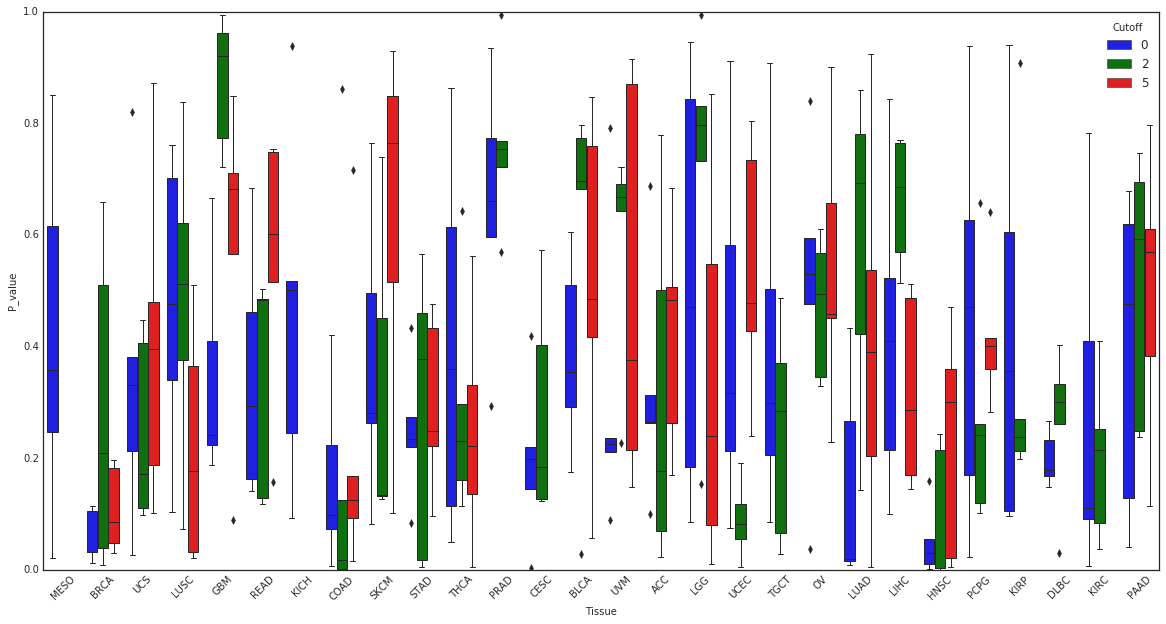

In [133]:
plt.figure(figsize=(20,10))
sns.boxplot(x='Tissue', y='P_value', data=results_df, hue='Cutoff')
plt.xticks(rotation=45)

In [34]:
results_df[(results_df.Tissue == 'PCPG')]

,Cutoff,Number_of_Mutations,P_value,Tissue
115,0,1018,0.001,PCPG
116,0,1018,0.060,PCPG
117,0,1018,0.018,PCPG
118,0,1018,0.195,PCPG
119,0,1018,0.038,PCPG
255,0,1018,0.440,PCPG
256,0,1018,0.294,PCPG
257,0,1018,0.073,PCPG
258,0,1018,0.066,PCPG
259,0,1018,0.730,PCPG


In [ ]:
# Cross validation with these ones
# COAD (5), HNSC (0), UCEC (5)

In [25]:
tissue, cutoff = 'UCEC', 5
tissue_patients = [x for x in list(tissue_df[tissue_df.Tissue == tissue].index) if x in patients]
other_patients = [x for x in list(pd.Series(tissue_df[tissue_df.Tissue != tissue].index)) if x in patients]
high_mutations = list(mutations.ix[tissue_patients].sum()[mutations.ix[tissue_patients].sum() >= cutoff].index)
both_restricted = both[high_mutations]
weight_shift = float(len(other_patients))/len(tissue_patients)
def is_tissue(x):
    if x == tissue:
        return 1
    else:
        return 0
tissue_df['Single'] = tissue_df['Tissue'].apply(is_tissue)
X = both_restricted.ix[tissue_patients + other_patients].as_matrix()
Y = list(tissue_df.ix[tissue_patients + other_patients].Single)

In [26]:
# X fold cross validation
clf = RandomForestClassifier(min_weight_fraction_leaf=.2, class_weight={1:weight_shift})
f1_scores = cross_validation.cross_val_score(clf, X, Y, cv=10, scoring=make_scorer(metrics.f1_score))
precision_scores = cross_validation.cross_val_score(clf, X, Y, cv=10, scoring=make_scorer(metrics.precision_score))
recall_scores = cross_validation.cross_val_score(clf, X, Y, cv=10, scoring=make_scorer(metrics.recall_score))
accuracy_scores = cross_validation.cross_val_score(clf, X, Y, cv=10, scoring=make_scorer(metrics.accuracy_score))
np.mean(f1_scores), np.mean(precision_scores), np.mean(recall_scores), np.mean(accuracy_scores)

(0.028153361197951466,
 0.01497358059326941,
 0.45952380952380939,
 0.6900486754702162)

In [30]:
random.shuffle(Y)
clf = RandomForestClassifier(min_weight_fraction_leaf=.2, class_weight={1:weight_shift})
f1_scores = cross_validation.cross_val_score(clf, X, Y, cv=10, scoring=make_scorer(metrics.f1_score))
precision_scores = cross_validation.cross_val_score(clf, X, Y, cv=10, scoring=make_scorer(metrics.precision_score))
recall_scores = cross_validation.cross_val_score(clf, X, Y, cv=10, scoring=make_scorer(metrics.recall_score))
accuracy_scores = cross_validation.cross_val_score(clf, X, Y, cv=10, scoring=make_scorer(metrics.accuracy_score))
np.mean(f1_scores), np.mean(precision_scores), np.mean(recall_scores), np.mean(accuracy_scores)

(0.022059497562729381,
 0.014192379341593408,
 0.37619047619047613,
 0.70304935575248506)

Cancer type vs non-cancer

HPV

In [2]:
hnsc_clinical = pd.read_csv('/cellar/users/ramarty/Data/kir/TCGA/hnsc_clinical/viral_status.csv', index_col=0)

In [4]:
hnsc_clinical.viral_status.value_counts()

Negative    80
Positive    44
Name: viral_status, dtype: int64

In [9]:
with open('/cellar/users/ramarty/Data/hpv/hnsc_viral_patients.txt', 'w') as outfile:
    for x in list(hnsc_clinical[hnsc_clinical.viral_status == 'Positive'].barcode):
        outfile.write('{0}\n'.format(x))

In [5]:
hnsc_clinical.p16.value_counts()

Negative    73
Positive    41
Name: p16, dtype: int64

In [6]:
hnsc_clinical.ish.value_counts()

Negative    66
Positive    22
Name: ish, dtype: int64

###Distinguishing between two tissues

In [583]:
THCA_patients = [x for x in classI.index if x in list(tissue_df[tissue_df.Tissue == 'THCA'].index)]
other_patients = [x for x in classI.index if x in list(tissue_df[tissue_df.Tissue == 'LUAD'].index)]

In [584]:
len(THCA_patients), len(other_patients)

(451, 522)

In [585]:
def is_thyroid(x):
    if x == 'THCA':
        return 'THCA'
    else:
        return 'Other'
tissue_df['THCA'] = tissue_df['Tissue'].apply(is_thyroid)

Mutation

In [586]:
mutations = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_mutations.csv', index_col=0)

In [587]:
X = mutations.ix[THCA_patients+other_patients].as_matrix()
Y = tissue_df.ix[THCA_patients+other_patients].THCA
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=40)

In [588]:
from sklearn import ensemble
clf = RandomForestClassifier()
clf = clf.fit(X_train, Y_train)

In [589]:
predicted = clf.predict(X_test)
matrix = []
for true_tissue in ['THCA', 'Other']:
    array = []
    for predicted_tissue in ['THCA', 'Other']:
        try:
        #if true_tissue == predicted_tissue:
            number_predicted = len([x for x,y in zip(list(Y_test), predicted) if x == true_tissue and y == predicted_tissue])
            number_true = len([x for x in Y_test if x == true_tissue])
            print true_tissue, predicted_tissue, number_true, number_predicted
            array.append(float(number_predicted)/float(number_true))
        except:
            array.append(np.nan)
    matrix.append(array)

THCA THCA 146 98
THCA Other 146 48
Other THCA 176 5
Other Other 176 171


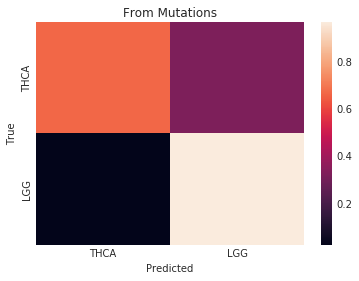

In [590]:
sns.heatmap(matrix, xticklabels=['THCA', 'LGG'], yticklabels=['THCA', 'LGG'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('From Mutations')

PHBR

In [591]:
classI = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_affinities.class_i.csv', index_col=0)
classII = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_affinities.class_ii.csv', index_col=0)
both = pd.concat([classI.transpose(), classII.transpose()]).transpose()

In [592]:
high_mutations = list(mutations.ix[THCA_patients+other_patients].sum()[mutations.ix[THCA_patients+other_patients].sum() >= 1].index)
len(high_mutations)

217

In [593]:
both_restricted = both[high_mutations].dropna()

In [594]:
X = both_restricted.ix[THCA_patients+other_patients].as_matrix()
Y = tissue_df.ix[THCA_patients+other_patients].THCA
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=40)

In [595]:
from sklearn import ensemble
clf = RandomForestClassifier()
clf = clf.fit(X_train, Y_train)

In [596]:
predicted = clf.predict(X_test)
matrix = []
for true_tissue in ['THCA', 'Other']:
    array = []
    for predicted_tissue in ['THCA', 'Other']:
        try:
        #if true_tissue == predicted_tissue:
            number_predicted = len([x for x,y in zip(list(Y_test), predicted) if x == true_tissue and y == predicted_tissue])
            number_true = len([x for x in Y_test if x == true_tissue])
            print true_tissue, predicted_tissue, number_true, number_predicted
            array.append(float(number_predicted)/float(number_true))
        except:
            array.append(np.nan)
    matrix.append(array)

THCA THCA 146 69
THCA Other 146 77
Other THCA 176 63
Other Other 176 113


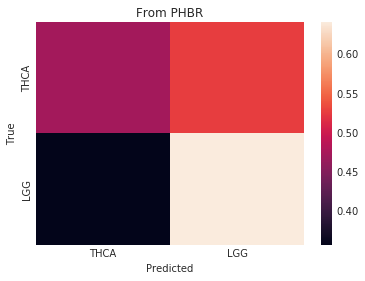

In [597]:
sns.heatmap(matrix, xticklabels=['THCA', 'LGG'], yticklabels=['THCA', 'LGG'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('From PHBR')

In [598]:
real = len([x for x,y in zip(Y_test, predicted) if x == y])/float(len(Y_test))
print real

0.565217391304


In [599]:
matrix

[[0.4726027397260274, 0.5273972602739726],
 [0.35795454545454547, 0.6420454545454546]]

In [600]:
accuracy = []
for i in range(1000):
    random.shuffle(predicted)
    matrix = []
    for true_tissue in ['THCA', 'Other']:
        array = []
        for predicted_tissue in ['THCA', 'Other']:
            try:
            #if true_tissue == predicted_tissue:
                number_predicted = len([x for x,y in zip(list(Y_test), predicted) if x == true_tissue and y == predicted_tissue])
                number_true = len([x for x in Y_test if x == true_tissue])
                #print true_tissue, predicted_tissue, number_true, number_predicted
                array.append(float(number_predicted)/float(number_true))
            except:
                array.append(np.nan)
        matrix.append(array)
    accuracy.append(len([x for x,y in zip(Y_test, predicted) if x == y])/float(len(Y_test)))
pd.Series(accuracy).hist(bins=20)
plt.axvline(real, lw=2, c='k')
plt.xlabel('Accuracy')

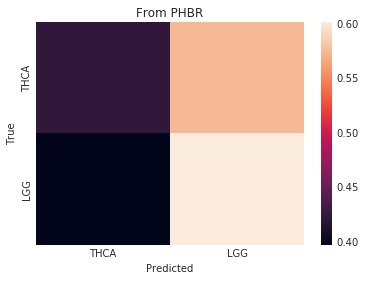

In [602]:
sns.heatmap(matrix, xticklabels=['THCA', 'LGG'], yticklabels=['THCA', 'LGG'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('From PHBR')

In [603]:
matrix

[[0.4246575342465753, 0.5753424657534246],
 [0.3977272727272727, 0.6022727272727273]]

In [604]:
len([x for x,y in zip(Y_test, predicted) if x == y])/float(len(x))

33.6